# Yelp MongoDB Analytics — Exploratory Analysis

This notebook explores restaurant data ingested from the Yelp Fusion API into MongoDB Atlas.

- Top categories by average rating
- Rating vs. review count
- Rating distribution by price level

Note: Ensure you've run the ingestion script and configured `.env` first.


In [1]:
# Imports and setup
import os
from dotenv import load_dotenv

import pandas as pd
import matplotlib.pyplot as plt

from pymongo import MongoClient

import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src.utils import get_mongo_collection
from src.query_mongodb import (
    average_rating_per_category,
    price_level_distribution,
    rating_reviewcount_pairs,
    ratings_by_price_level,
)

# Inline plots
%matplotlib inline
plt.style.use('ggplot')

# Load env variables (for completeness if ran outside root)
load_dotenv(os.path.join('..', '.env'))

collection = get_mongo_collection()


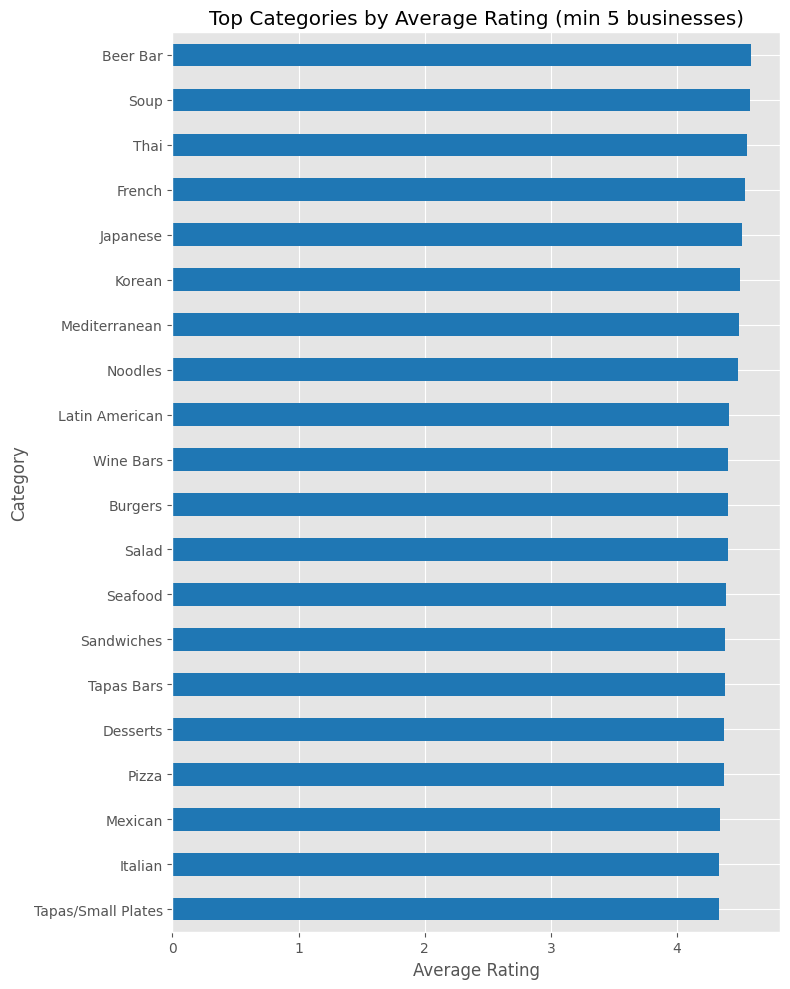

,avg_rating,num_businesses,category
0,4.585714,7,Beer Bar
1,4.580000,5,Soup
2,4.557143,7,Thai
3,4.537500,8,French
4,4.516667,12,Japanese


In [2]:
# Top categories by average rating
results = average_rating_per_category(collection, min_businesses=5)
df_cat = pd.DataFrame(results)

# Keep top 20 for readability
df_top = df_cat.head(20)

ax = df_top.plot(kind='barh', x='category', y='avg_rating', legend=False, figsize=(8, 10), color='#1f77b4')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Category')
ax.set_title('Top Categories by Average Rating (min 5 businesses)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

df_top.head()


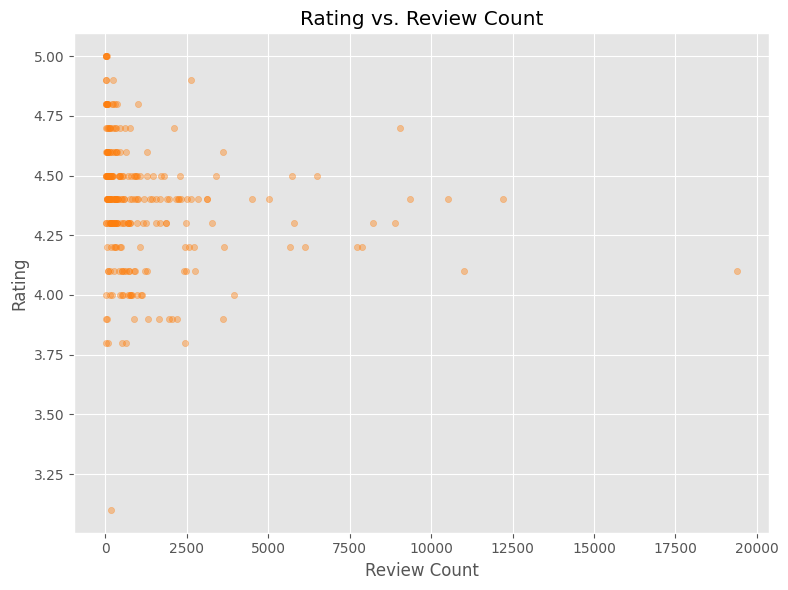

,rating,review_count
count,250.000000,250.000000
mean,4.376000,1267.328000
std,0.269284,2308.301551
min,3.100000,1.000000
25%,4.200000,135.500000
50%,4.400000,449.500000
75%,4.500000,1267.250000
max,5.000000,19407.000000


In [3]:
# Rating vs. review count (scatter)
results = rating_reviewcount_pairs(collection, min_review_count=0)
df_pairs = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_pairs['review_count'], df_pairs['rating'], alpha=0.4, s=20, c='#ff7f0e')
ax.set_xlabel('Review Count')
ax.set_ylabel('Rating')
ax.set_title('Rating vs. Review Count')
plt.tight_layout()
plt.show()

df_pairs.describe()


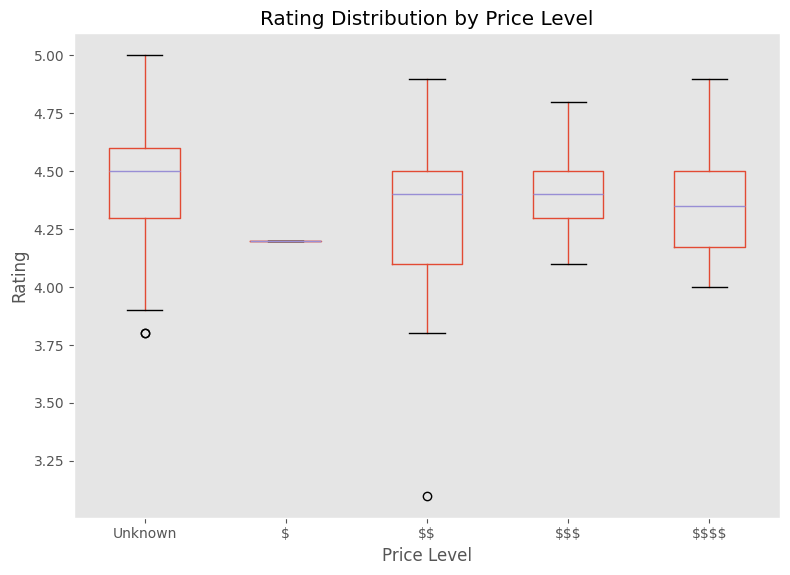

/tmp/ipykernel_190979/4283965286.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_price.groupby('price').rating.describe()


,count,mean,std,min,25%,50%,75%,max
price,,,,,,,,
$,1.0,4.200000,NaN,4.2,4.200,4.20,4.2,4.2
$$,111.0,4.320721,0.278345,3.1,4.100,4.40,4.5,4.9
$$$,50.0,4.374000,0.173570,4.1,4.300,4.40,4.5,4.8
$$$$,12.0,4.366667,0.283912,4.0,4.175,4.35,4.5,4.9
Unknown,76.0,4.461842,0.288429,3.8,4.300,4.50,4.6,5.0


In [8]:
# Rating distribution by price level
results = ratings_by_price_level(collection)
df_price = pd.DataFrame(results)

# Normalize price labels
price_order = ['$', '$$', '$$$', '$$$$', 'Unknown']
df_price['price'] = pd.Categorical(df_price['price'], categories=price_order, ordered=True)
df_price['price_display'] = df_price['price'].astype(str).str.replace('$', r'\$', regex=False)

ax = df_price.boxplot(column='rating', by='price_display', grid=False, figsize=(8, 6))
plt.suptitle('')
plt.title('Rating Distribution by Price Level')
plt.xlabel('Price Level')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

df_price.groupby('price').rating.describe()


In [9]:
# Correlation between review count and rating
from scipy.stats import pearsonr

if len(df_pairs) > 1:
    corr, pval = pearsonr(df_pairs['review_count'], df_pairs['rating'])
    print(f"Pearson r: {corr:.4f} (p={pval:.4g})")
else:
    print("Not enough data for correlation.")


Pearson r: -0.1434 (p=0.02334)
